#### Explore Spark Exercises

These exercises should go in a notebook or script named `explore`. 

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [3]:
import pyspark.sql
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import wrangle

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()

plt.rc('figure', figsize = (13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size = 12)

In [4]:
df = wrangle.wrangle_311(spark)
df.show(1, vertical = True, truncate = False)

[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments
-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207        

- How many different cases are there, by department?
    - Solid Waste has **56 distinct and 279,270 different cases**
    - Animal Care Services has **14 distinct and 116,915 different cases**
    - Trans & Cap Improvements has **81 distinct and 96,193 different cases**
    - Parks & Recreation has **44 distinct and 19,907 different cases**
    - Customer Service has **2 distinct and 2,849 different cases**
    - Metro Health has **14 distinct and 5,163 different cases**
    - City Council has **2 distinct and 33 different cases**
    - DSD/Code Enforcement has **122 distinct and 321,374 different cases**

In [5]:
(df.groupBy('department')
 # countDistinct counts each unique case rather than all cases
 .agg(countDistinct('service_request_type')
 .alias('distinct number of cases')).show(truncate = False))

+------------------------+------------------------+
|department              |distinct number of cases|
+------------------------+------------------------+
|Solid Waste             |56                      |
|Animal Care Services    |14                      |
|Trans & Cap Improvements|81                      |
|Parks & Recreation      |44                      |
|Customer Service        |2                       |
|Metro Health            |14                      |
|City Council            |2                       |
|DSD/Code Enforcement    |122                     |
+------------------------+------------------------+



In [6]:
(df.groupBy('department')
 .agg(count('service_request_type')
 .alias('number of cases')).show(truncate = False))

+------------------------+---------------+
|department              |number of cases|
+------------------------+---------------+
|Solid Waste             |279270         |
|Animal Care Services    |116915         |
|Trans & Cap Improvements|96193          |
|Parks & Recreation      |19907          |
|Customer Service        |2849           |
|Metro Health            |5163           |
|City Council            |33             |
|DSD/Code Enforcement    |321374         |
+------------------------+---------------+



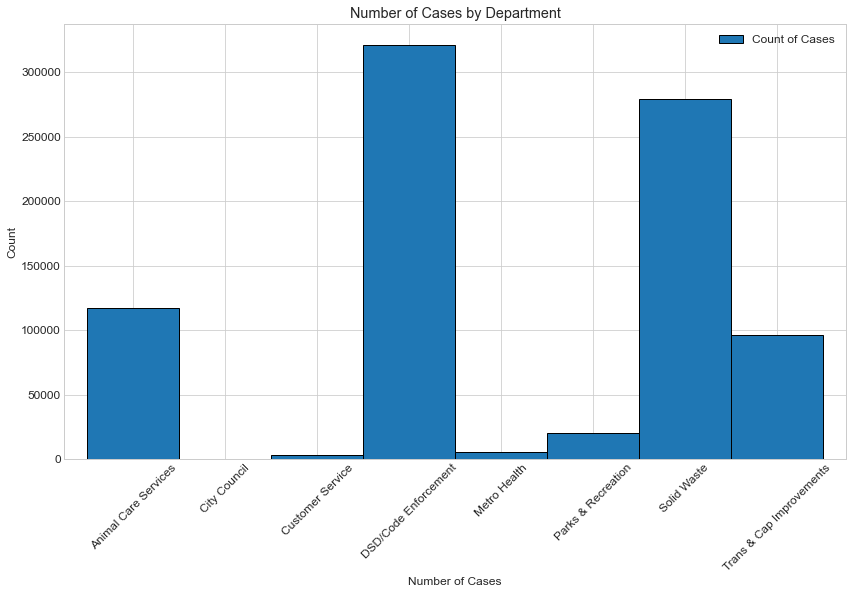

In [7]:
(df.groupBy('department')
 .agg(count('service_request_type').alias('Count of Cases'))
 .toPandas()
 .set_index('department')
 .sort_values(by = 'department')
 .plot.bar(width = 1, ec = 'black', figsize = (14, 8)))

plt.title('Number of Cases by Department')
plt.ylabel('Count')
plt.xlabel('Number of Cases')
plt.xticks(rotation = 45);

- Does the percentage of cases that are late vary by department?
    - Yes, the percentages of cases that are late **range from .00% to 70.55%**

In [8]:
(df.withColumn('case_late', col('case_late').cast('int'))
 .groupBy('department')
 .agg(concat(round(avg('case_late') * 100, 2), lit(' %'))
      .alias('percentage_of_cases_that_are_late'))
 .show(truncate = False))

+------------------------+---------------------------------+
|department              |percentage_of_cases_that_are_late|
+------------------------+---------------------------------+
|Solid Waste             |11.8 %                           |
|Animal Care Services    |19.91 %                          |
|Trans & Cap Improvements|5.63 %                           |
|Parks & Recreation      |19.07 %                          |
|Customer Service        |70.55 %                          |
|Metro Health            |16.06 %                          |
|City Council            |0.0 %                            |
|DSD/Code Enforcement    |8.16 %                           |
+------------------------+---------------------------------+



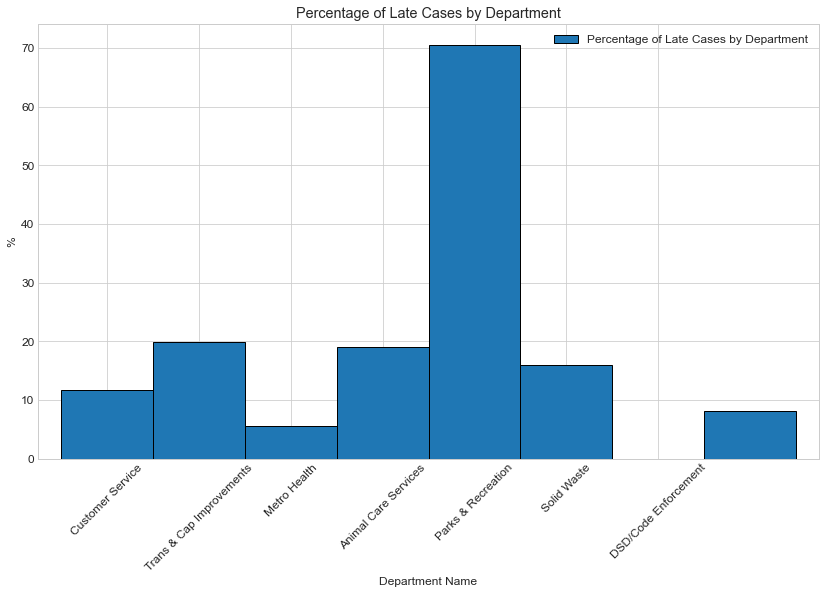

In [9]:
(df.withColumn('case_late', col('case_late').cast('int'))
 .groupBy('department')
 .agg(round(avg('case_late') * 100, 2)
      .alias('Percentage of Late Cases by Department'))
 .toPandas()
 .plot.bar(width = 1, ec = 'black', figsize = (14, 8)))

plt.title('Percentage of Late Cases by Department')
plt.ylabel('%')
plt.xlabel('Department Name')
plt.xticks(rotation = 45, ticks = np.arange(7), labels = ['Customer Service', 
                                                          'Trans & Cap Improvements',
                                                          'Metro Health',
                                                          'Animal Care Services',
                                                          'Parks & Recreation',
                                                          'Solid Waste', 
                                                          'DSD/Code Enforcement']);

In [10]:
(df.groupBy('department', 'case_late')
 .count()
 .filter(df.case_late == 'true')
 .withColumn('proportion_of_late_cases_by_department', 
             concat(round(col('count') / df.filter(df.case_late == 'true')
             .count() * 100, 2), 
             lit(' %')))
 .show(truncate = False))

+------------------------+---------+-----+--------------------------------------+
|department              |case_late|count|proportion_of_late_cases_by_department|
+------------------------+---------+-----+--------------------------------------+
|Customer Service        |true     |2010 |2.13 %                                |
|Trans & Cap Improvements|true     |5411 |5.73 %                                |
|Metro Health            |true     |829  |0.88 %                                |
|Animal Care Services    |true     |23276|24.63 %                               |
|Parks & Recreation      |true     |3797 |4.02 %                                |
|Solid Waste             |true     |32945|34.86 %                               |
|DSD/Code Enforcement    |true     |26235|27.76 %                               |
+------------------------+---------+-----+--------------------------------------+



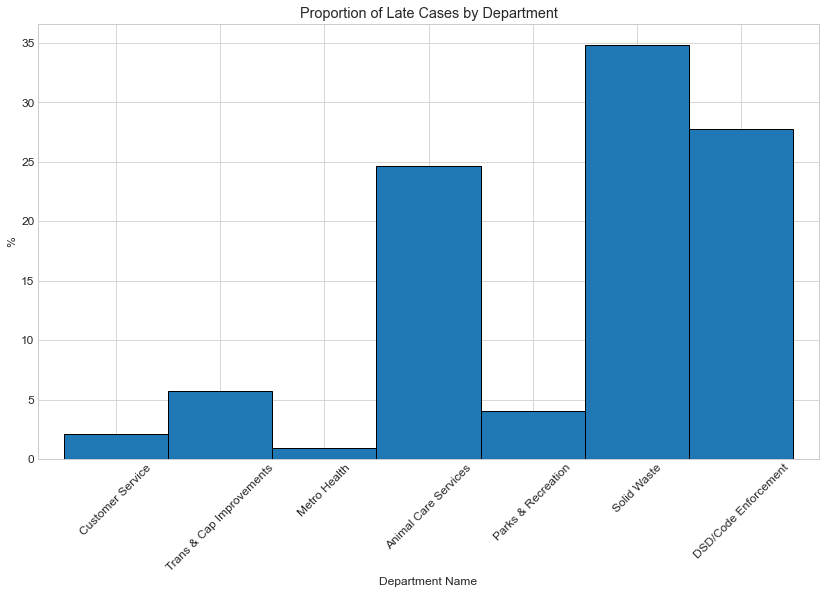

In [11]:
(df.groupBy('department', 'case_late')
 .count()
 .filter(df.case_late == 'true')
 .withColumn('proportion of cases that are late', 
             round(col('count') / df.filter(df.case_late == 'true')
             .count() * 100, 2), 
             )
 .toPandas()['proportion of cases that are late']
 .plot.bar(width = 1, ec = 'black', figsize = (14, 8))
) 


plt.title('Proportion of Late Cases by Department')
plt.ylabel('%')
plt.xlabel('Department Name')
plt.xticks(rotation = 45, ticks = np.arange(7), labels = ['Customer Service', 
                                                          'Trans & Cap Improvements',
                                                          'Metro Health',
                                                          'Animal Care Services',
                                                          'Parks & Recreation',
                                                          'Solid Waste', 
                                                          'DSD/Code Enforcement']);

- On average, how late are the late cases by department?
 - Customer Service: **87.68 days**
 - Trans & Cap Improvements: plot hole repair with **10.6 days**
 - Metro Health: license renewal invoice with **6.54 days**
 - Animal Care Services: stray animal with **23.46 days**
 - Parks & Recreation: carpentry with **22.35 days**
 - Solid Waste: no pickup with **7.19 days**
 - DSD/Code Enforcement: overgrown yard/trash with **49.38 days**



In [12]:
(df.groupBy('department', 'case_late')
 .agg(round(avg('num_days_late'), 2).alias('avg_days_late'))
 .filter(df.case_late == 'true').show(truncate = False)
)

+------------------------+---------+-------------+
|department              |case_late|avg_days_late|
+------------------------+---------+-------------+
|Customer Service        |true     |87.68        |
|Trans & Cap Improvements|true     |10.6         |
|Metro Health            |true     |6.54         |
|Animal Care Services    |true     |23.46        |
|Parks & Recreation      |true     |22.35        |
|Solid Waste             |true     |7.19         |
|DSD/Code Enforcement    |true     |49.38        |
+------------------------+---------+-------------+



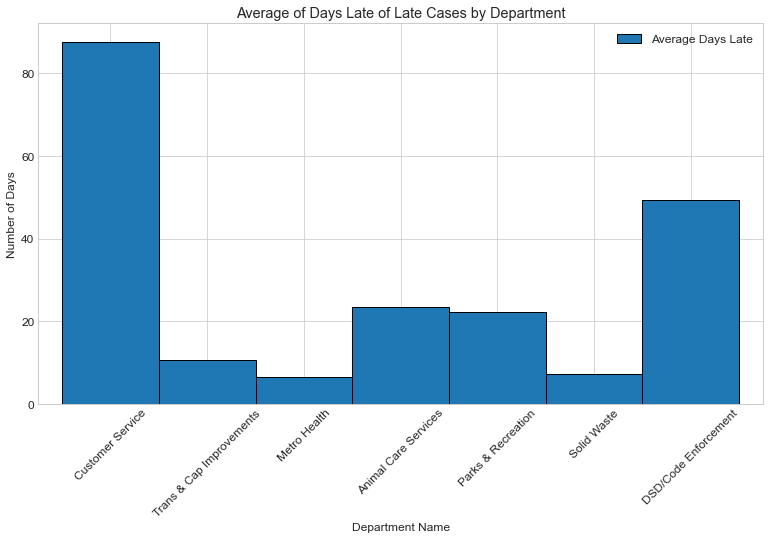

In [13]:
(df.groupBy('department', 'case_late')
 .agg(round(avg('num_days_late'), 2).alias('Average Days Late'))
 .filter(df.case_late == 'true')
 .toPandas()
 .plot.bar(width = 1, ec = 'black')
)

plt.title('Average of Days Late of Late Cases by Department')
plt.ylabel('Number of Days')
plt.xlabel('Department Name')
plt.xticks(rotation = 45, ticks = np.arange(7), labels = ['Customer Service', 
                                                          'Trans & Cap Improvements',
                                                          'Metro Health',
                                                          'Animal Care Services',
                                                          'Parks & Recreation',
                                                          'Solid Waste', 
                                                          'DSD/Code Enforcement']);

- What is the service type that is the most late? Just for Parks & Rec?
    - Overall: Zoning: Recycle Yard taking an average of **210.89 days**
    - For Parks & Rec: Amenity Park Improvement taking an average of **76.89 days**

In [14]:
(df.groupBy('service_request_type', 'case_late')
 .agg(round(avg('num_days_late'),2).alias('avg_days_late'))
 .filter(df.case_late == 'true')
).toPandas().sort_values(by = 'avg_days_late').tail(1)

,service_request_type,case_late,avg_days_late
113,Zoning: Recycle Yard,True,210.89


In [15]:
(df.groupBy('department', 'service_request_type', 'case_late')
 .agg(round(avg('num_days_late'),2).alias('avg_days_late'))
 .filter(df.department == 'Parks & Recreation')
 .filter(df.case_late == 'true')
).toPandas().sort_values(by = 'avg_days_late').tail(1)

,department,service_request_type,case_late,avg_days_late
26,Parks & Recreation,Amenity Park Improvement,True,76.87


- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
 - Customer Service: complaint with **2,388 requests**
 - Trans & Cap Improvements: plot hole repair with **20,616 requests**
 - Metro Health: license renewal invoice with **1,349 requests**
 - Animal Care Services: stray animal with **26,760 requests**
 - Parks & Recreation: carpentry with **1,944 requests**
 - Solid Waste: no pickup with **86,855 requests**
 - DSD/Code Enforcement: overgrown yard/trash with **65,895 requests**


In [12]:
departments = ['Customer Service', 'Trans & Cap Improvements', 'Metro Health', 'Animal Care Services', 'Parks & Recreation', 'Solid Waste', 'DSD/Code Enforcement']

In [56]:
for department in departments:
    display((df.groupBy('department', 'service_request_type')
     .agg(count('service_request_type').alias('number_of_service_requests'))
     .filter(df.department == department)
     .toPandas().sort_values(by = 'number_of_service_requests').tail(1)
    ))

,department,service_request_type,number_of_service_requests
1,Customer Service,Complaint,2388


,department,service_request_type,number_of_service_requests
70,Trans & Cap Improvements,Pot Hole Repair,20616


,department,service_request_type,number_of_service_requests
2,Metro Health,License Renewal Invoice,1349


,department,service_request_type,number_of_service_requests
5,Animal Care Services,Stray Animal,26760


,department,service_request_type,number_of_service_requests
16,Parks & Recreation,Carpentry,1944


,department,service_request_type,number_of_service_requests
25,Solid Waste,No Pickup,86855


,department,service_request_type,number_of_service_requests
66,DSD/Code Enforcement,Overgrown Yard/Trash,65895


- Does whether or not its a weekend matter for when a case is opened/closed?

In [17]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

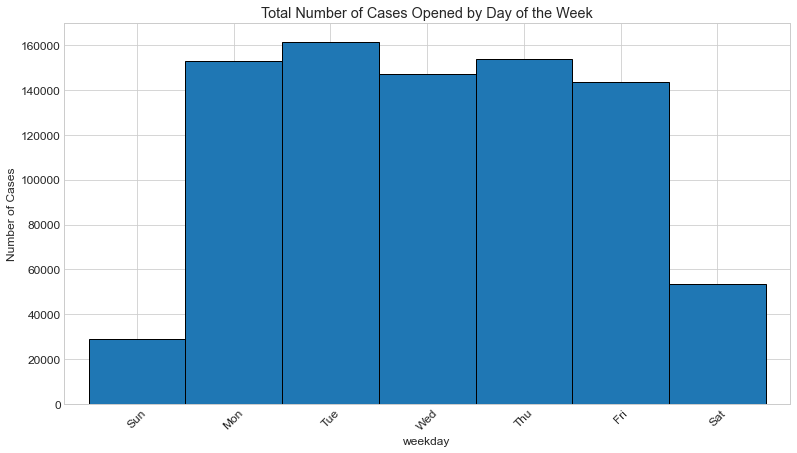

In [18]:
(df.withColumn('weekday', date_format('case_opened_date', 'E'))
 .groupBy('weekday')
 .count()
 .na.drop()
 .toPandas()
 .assign(weekday = lambda df: pd.Categorical(df.weekday, categories = weekdays, ordered = True))
 .set_index('weekday')['count']
 .sort_index()
 .plot.bar(width = 1, ec = 'black')
)

plt.xticks(rotation = 45)
plt.title('Total Number of Cases Opened by Day of the Week')
plt.ylabel('Number of Cases');

- On average, how many cases are opened a day for the Customer Service department?

In [19]:
(df.withColumn('case_opened_late', expr('date(case_opened_date)'))
 .filter(df.department == 'Customer Service')
 .groupBy('case_opened_late')
 .count()
 .toPandas()
 ['count'].mean()
)

5.564453125

- Does the number of service requests for the solid waste department vary by day of the week?

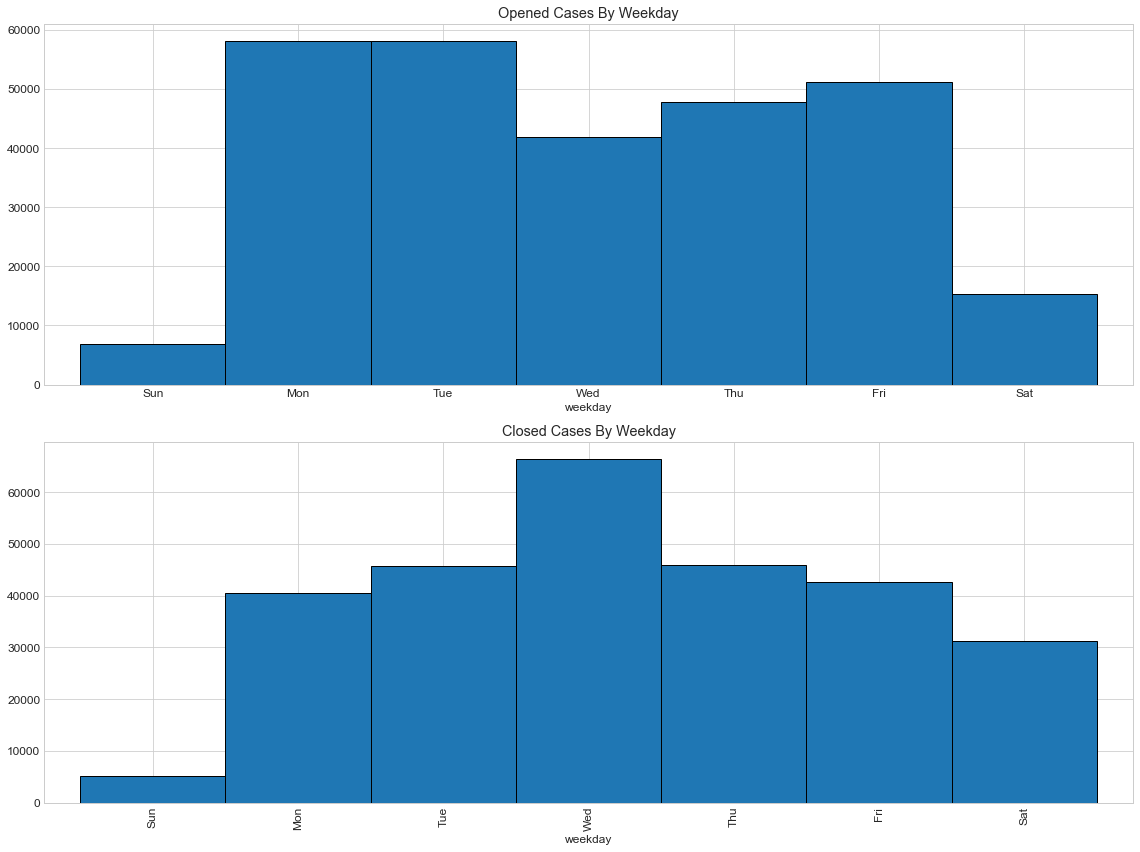

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 12))

(
    df.withColumn('weekday', date_format('case_opened_date', 'E'))
    .filter(expr('department == "Solid Waste"'))
    .groupby('weekday')
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday = lambda df: pd.Categorical(df.weekday, categories = weekdays, ordered = True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax = ax1, width = 1, ec = 'black')
)
ax1.set(
    title = 'Opened Cases By Weekday'
)
ax1.tick_params(axis = 'x', labelrotation = 0)


(
    df.withColumn('weekday', date_format('case_closed_date', 'E'))
    .filter(expr('department == "Solid Waste"'))
    .groupby('weekday')
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday = lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax = ax2, width = 1, ec = 'black')
)
ax2.set(
    title = 'Closed Cases By Weekday'
)
fig.tight_layout()